# **Introduction**

Dans ce projet, nous allons fine-tuner le modèle de langage **GPT2** en utilisant le dataset **Instruction-Poems**. L'objectif est de créer un modèle capable de générer des poèmes cohérents, créatifs, et adaptés à des instructions spécifiques. Ce projet implique une exploration approfondie des données, un nettoyage méthodique, une préparation minutieuse pour l'entraînement, et une évaluation rigoureuse des performances du modèle.



#**1. Exploration des données**

Installation des Dépendances Nécessaires

In [3]:
!pip install transformers[torch] datasets

In [4]:
!pip install bitsandbytes trl peft tqdm

In [5]:
!pip install accelerate tqdm rouge-score

In [6]:
!pip install flash-attn --no-build-isolation

Chargement des Bibliothèques

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset

Chargement des Jeux de Données

In [8]:
ds = load_dataset("checkai/instruction-poems")

In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['INSTRUCTION', 'RESPONSE', 'SOURCE', 'METADATA'],
        num_rows: 13854
    })
})

Conversion de `df` en DataFrame

In [10]:
df = pd.DataFrame(ds['train'])

In [11]:
df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
0,"Compose a poem, about Living,Death,The Body,Na...","I've written a poem for you about Living,Death...",PoetryFoundation.org - kari edwards,"{""author"": ""kari edwards"", ""title"": ""\""[ready ..."
1,"Make a poem with themes of Religion,Faith & Do...","Here's a beautiful poem about Religion,Faith &...",PoetryFoundation.org - Thomas P. Lynch,"{""author"": ""Thomas P. Lynch"", ""title"": ""\""Argy..."
2,"Make a poem with themes of Religion,Faith & Do...","Sure, I can do that. Here's a poem about Relig...",PoetryFoundation.org - Robert Bly,"{""author"": ""Robert Bly"", ""title"": ""\""Wanting S..."
3,"Write me a poem about Religion,Faith & Doubt,G...","Here's a poem I composed about Religion,Faith ...",PoetryFoundation.org - Sheena Raza Faisal,"{""author"": ""Sheena Raza Faisal"", ""title"": ""\""a..."
4,"Write me a poem about Living,Growing Old,Natur...","It's called ""February Evening in New York"": \n...",PoetryFoundation.org - Denise Levertov,"{""author"": ""Denise Levertov"", ""title"": ""\""Febr..."


In [12]:
df.shape

(13854, 4)

À cette étape, nous divisons le dataset `df` en ensembles d'entraînement, de test et de validation.

In [13]:
train_df, test_df, validation_df = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [14]:
train_df.shape, test_df.shape, validation_df.shape

((11083, 4), (1385, 4), (1386, 4))

Dans cette étape, nous sélectionnons un sous-ensemble de l'ensemble d'entraînement. Cela permet de réduire la taille des données pour un traitement plus rapide lors des phases de développement et de test.

In [15]:
train_df = train_df.sample(frac=0.2, random_state=42)

In [16]:
train_df.shape

(2217, 4)

In [17]:
test_df= test_df.sample(frac=0.2, random_state=42)
test_df.shape

(277, 4)

In [18]:
validation_df= validation_df.sample(frac=0.2, random_state=42)
validation_df.shape

(277, 4)

Afficher un aperçu des datasets

In [19]:
train_df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
7187,Make a poem with themes of Social Commentaries...,"Okay, a poem about Social Commentaries,Cities ...",PoetryFoundation.org - Louise Imogen Guiney,"{""author"": ""Louise Imogen Guiney"", ""title"": ""\..."
12947,"Make a poem with themes of Living,Nature,Anima...","Sure, I can do that. Here's a poem about Livin...",PoetryFoundation.org - Knar Gavin,"{""author"": ""Knar Gavin"", ""title"": ""\""Statocyst..."
10935,"Compose a poem, about Living,Infancy,Parenthoo...","Of course! It's called ""Tinnitus: May, low ski...",PoetryFoundation.org - David Harsent,"{""author"": ""David Harsent"", ""title"": ""\""Tinnit..."
2721,"Make a poem with themes of Activities,Jobs & W...","Here's a beautiful poem about Activities,Jobs ...",PoetryFoundation.org - David Rivard,"{""author"": ""David Rivard"", ""title"": ""\""Torque\..."
10409,"Can you write a poem? Make it about Living,Gro...","Here's a beautiful poem about Living,Growing O...",PoetryFoundation.org - Larry Levis,"{""author"": ""Larry Levis"", ""title"": ""\""Winter S..."


In [20]:
test_df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
12086,"I want a poem about Activities,Travels & Journ...","I've written a poem for you about Activities,T...",PoetryFoundation.org - Douglas Kearney,"{""author"": ""Douglas Kearney"", ""title"": ""\""Afro..."
13246,Title this poem: \nI\r\n\r\nThe spider expects...,"How about calling it ""The Spider""?",PoetryFoundation.org - Richard Eberhart,"{""author"": ""Richard Eberhart"", ""title"": ""\""The..."
5901,"Make a poem with themes of Living,Love,Relatio...","Of course! It's called ""The Window"": \nyou are...",PoetryFoundation.org - Diane di Prima,"{""author"": ""Diane di Prima"", ""title"": ""\""The W..."
5420,"Compose a poem, about Living,Death,Marriage & ...","I've written a poem for you about Living,Death...",PoetryFoundation.org - Donald Davie,"{""author"": ""Donald Davie"", ""title"": ""\""No Epit..."
3493,"Compose a poem, about Love,Break-ups & Vexed L...","I've written a poem for you about Love,Break-u...",PoetryFoundation.org - Edmund Spenser,"{""author"": ""Edmund Spenser"", ""title"": ""\""Amore..."


In [21]:
validation_df.head()

,INSTRUCTION,RESPONSE,SOURCE,METADATA
1542,"Compose a poem, about Life Choices,Arts & Scie...","Of course! It's called ""The God Called Poetry""...",PoetryFoundation.org - Robert Graves,"{""author"": ""Robert Graves"", ""title"": ""\""The Go..."
260,"Can you write a poem? Make it about Living,Dea...","Of course! It's called ""Immortality Ode"": \nMi...",PoetryFoundation.org - Bruce Smith,"{""author"": ""Bruce Smith"", ""title"": ""\""Immortal..."
7455,"Compose a poem, about Religion,God & the Divin...","It's called ""Reemergence of the Noose"": \nSome...",PoetryFoundation.org - Patricia Smith,"{""author"": ""Patricia Smith"", ""title"": ""\""Reeme..."
7651,"I want a poem about Activities,Travels & Journ...","Here's your poem about Activities,Travels & Jo...",PoetryFoundation.org - Mark Rudman,"{""author"": ""Mark Rudman"", ""title"": ""\""Provo\""""..."
10262,"Write me a poem about Living,Death,Parenthood,...","I've written a poem for you about Living,Death...",PoetryFoundation.org - Mary Karr,"{""author"": ""Mary Karr"", ""title"": ""\""Requiem fo..."


Exploration de Quelques Lignes de Notre Dataset d’Entraînement

In [22]:
train_df['INSTRUCTION'][7187]

'Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.'

In [23]:
train_df['RESPONSE'][7187]

'Okay, a poem about Social Commentaries,Cities & Urban Life: \n"The Lights of London"\nThe evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure Her tear by day, her fevered smile by night.'

In [24]:
train_df['SOURCE'][7187]

'PoetryFoundation.org - Louise Imogen Guiney'

In [25]:
train_df['METADATA'][7187]

'{"author": "Louise Imogen Guiney", "title": "\\"The Lights of London\\"", "tags": "Social Commentaries,Cities & Urban Life", "task_type": "writing"}'

Comme on peut le remarquer, `METADATA` ne sera pas vraiment utile pour l'entraînement de notre modèle, contrairement à `RESPONSE`, `SOURCE` et `INSTRUCTION`, que nous allons conserver pour l'entraînement.

Nous allons concaténer `Response` et `Source` pour déterminer, pour chaque poème généré, sa source.

In [26]:
response = f"{train_df['RESPONSE'][7187]} \nSource: {train_df['SOURCE'][7187]}"

In [27]:
print(response)

Okay, a poem about Social Commentaries,Cities & Urban Life: 
"The Lights of London"
The evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure Her tear by day, her fevered smile by night. 
Source: PoetryFoundation.org - Louise Imogen Guiney


In [28]:
for index, row in train_df.iterrows():
  i = index
  train_df.loc[index, 'RESPONSE'] = f"{row['RESPONSE']} \nSource: {row['SOURCE']}"

In [29]:
for index, row in test_df.iterrows():
  i = index
  test_df.loc[index, 'RESPONSE'] = f"{row['RESPONSE']} \nSource: {row['SOURCE']}"

In [30]:
for index, row in validation_df.iterrows():
  i = index
  validation_df.loc[index, 'RESPONSE'] = f"{row['RESPONSE']} \nSource: {row['SOURCE']}"

In [31]:
print(train_df['RESPONSE'][7187])

Okay, a poem about Social Commentaries,Cities & Urban Life: 
"The Lights of London"
The evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure Her tear by day, her fevered smile by night. 
Source: PoetryFoundation.org - Louise Imogen Guiney


In [32]:
train_df = train_df[['INSTRUCTION',	'RESPONSE']]
test_df = test_df[['INSTRUCTION',	'RESPONSE']]
validation_df = validation_df[['INSTRUCTION',	'RESPONSE']]

**Vérification des valeurs manquantes**

In [33]:
train_df.isnull().sum()

,0
INSTRUCTION,0
RESPONSE,0


In [34]:
test_df.isnull().sum()

,0
INSTRUCTION,0
RESPONSE,0


In [35]:
validation_df.isnull().sum()

,0
INSTRUCTION,0
RESPONSE,0


D'après ces résultats, on peut bien remarquer qu'aucune valeur manquante n'a été détectée dans les colonnes `INSTRUCTION` et `RESPONSE` des ensembles d'entraînement, de test, et de validation. Cela garantit que le dataset est complet et prêt pour les étapes suivantes.

**Description statistique des colonnes du dataset d'entraînement**

In [36]:
train_desciption = train_df.describe()

In [37]:
train_desciption

,INSTRUCTION,RESPONSE
count,2217,2217
unique,1902,2217
top,Compose a poem.,"Sure, I can do that. Here's a poem about The B..."
freq,30,1


**Affichage des instruction et de la reponse les plus fréquents**

In [38]:
top_INSTRUCTION = train_desciption['INSTRUCTION'].iloc[2]
print("Top INSTRUCTION :", top_INSTRUCTION)

Top INSTRUCTION : Compose a poem.


**1. Analyse de la colonne `INSTRUCTION`**
- **Count** : La colonne contient **2217 instructions**, ce qui correspond au nombre total d'entrées dans le dataset.
- **Unique** : Elle compte **1902 instructions uniques**, ce qui montre qu'il existe des doublons dans les instructions.
- **Top** : L'instruction la plus fréquente est **`"Compose a poem."`**, qui est une demande générique pour un poème.
- **Frequency** : Cette instruction apparaît **30 fois**, ce qui suggère qu'une part notable du dataset est composée de cette demande spécifique.

**2. Analyse de la colonne `RESPONSE`**
- **Count** : La colonne contient également **2217 réponses**, ce qui correspond parfaitement au nombre d'instructions. Cela montre qu'il y a une réponse pour chaque instruction.
- **Unique** : Toutes les réponses sont **uniques** (2217 uniques), ce qui signifie que chaque poème généré est distinct, même si certaines instructions se répètent.
- **Top** : La réponse la plus fréquente commence par **`"	Sure, I can do that. Here's a poem about The B..."`**.
- **Frequency** : Cette réponse apparaît **une seule fois**, ce qui confirme la diversité des poèmes générés.

**Description statistique des colonnes du dataset de validation**

In [39]:
validation_df.describe()

,INSTRUCTION,RESPONSE
count,277,277
unique,260,277
top,Write me a poem.,"Here's a beautiful poem about Living,Coming of..."
freq,5,1


**1. Analyse de la colonne `INSTRUCTION`**
- **Count** : La colonne contient **277 instructions**, ce qui correspond au nombre total d'entrées dans l'ensemble de validation.
- **Unique** : Elle compte **260 instructions uniques**, ce qui montre qu'il existe des doublons parmi les instructions.
- **Top** : L'instruction la plus fréquente est **`"Writre me a poem."`**, qui semble être une demande générique pour un poème.
- **Frequency** : Cette instruction apparaît **5 fois**, ce qui indique qu'elle est relativement fréquente.

**2. Analyse de la colonne `RESPONSE`**
- **Count** : La colonne contient également **277 réponses**, ce qui correspond parfaitement au nombre d'instructions. Cela montre qu'il y a une réponse pour chaque instruction.
- **Unique** : Toutes les réponses sont **uniques** (277 uniques), ce qui signifie que chaque poème généré est distinct dans l'ensemble de validation.
- **Top** : La réponse la plus fréquente commence par **`"Here's a beautiful poem about Living,Coming of..."`**.
- **Frequency** : Cette réponse apparaît **une seule fois**, ce qui confirme que les réponses sont diverses et non répétées.

**Description statistique des colonnes du dataset de test**

In [40]:
test_df.describe()

,INSTRUCTION,RESPONSE
count,277,277
unique,261,277
top,I want a poem.,"Here's a poem I composed about Activities,Trav..."
freq,6,1


**1. Analyse de la colonne `INSTRUCTION`**
- **Count** : La colonne contient **277 instructions**, ce qui correspond au nombre total d'exemples dans l'ensemble de test.
- **Unique** : Elle compte **261 instructions uniques**, ce qui montre qu'il existe des doublons dans les instructions.
- **Top** : L'instruction la plus fréquente est **`"I want a poem."`**, une demande générique de poème.
- **Frequency** : Cette instruction apparaît **6 fois**, ce qui, indique une répétition modérée.

**2. Analyse de la colonne `RESPONSE`**
- **Count** : La colonne contient également **277 réponses**, correspondant parfaitement au nombre d'instructions. Cela montre qu'il y a une réponse pour chaque instruction dans l'ensemble de test.
- **Unique** : Toutes les réponses sont **uniques** (277 uniques), ce qui signifie que chaque poème généré est distinct.
- **Top** : La réponse la plus fréquente commence par **`"Here's a poem I composed about Activities,Trav..."`**.
- **Frequency** : Cette réponse apparaît **une seule fois**, confirmant que l'ensemble de test présente une grande diversité dans les réponses.

**Analyse des Longueurs des instruction et response**


In [41]:
from collections import Counter

In [42]:
train_df['INSTRUCTION_length'] = train_df['INSTRUCTION'].apply(len)
train_df['RESPONSE_length'] = train_df['RESPONSE'].apply(len)

# Statistiques descriptives
train_df[['INSTRUCTION_length', 'RESPONSE_length']].describe()

,INSTRUCTION_length,RESPONSE_length
count,2217.000000,2217.000000
mean,174.997294,1548.333333
std,528.961460,2230.326991
min,12.000000,75.000000
25%,66.000000,666.000000
50%,97.000000,1054.000000
75%,146.000000,1720.000000
max,19026.000000,54365.000000


- Les instructions ont une longueur moyenne de **174 caractères**, avec un minimum de **12** et un maximum de **19026 caractères**, montrant une grande variabilité. La plupart des instructions sont courtes, comme indiqué par le troisième quartile (**146 caractères**), mais l'écart-type élevé (**528 caractères**) révèle la présence de quelques instructions extrêmement longues.

- Les réponses ont une longueur moyenne de **1 548 caractères**, avec un minimum de **75** et un maximum de **54 365 caractères**, soulignant une diversité encore plus marquée. Bien que la majorité des réponses soient modérées (75 % ≤ **1 720 caractères**), l'écart-type élevé (**2230 caractères**) met en évidence des poèmes très longs qui pourraient nécessiter une troncature pour un traitement efficace.

**Répartition des Catégories de Longueur**

In [43]:
def categorize_length(length):
    if length < 50:
        return 'Court'
    elif 50 <= length < 150:
        return 'Moyen'
    else:
        return 'Long'

train_df['INSTRUCTION_category'] = train_df['INSTRUCTION_length'].apply(categorize_length)
train_df['RESPONSE_category'] = train_df['RESPONSE_length'].apply(categorize_length)

<ipython-input-44-04b6cbd5d1cf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='INSTRUCTION_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])


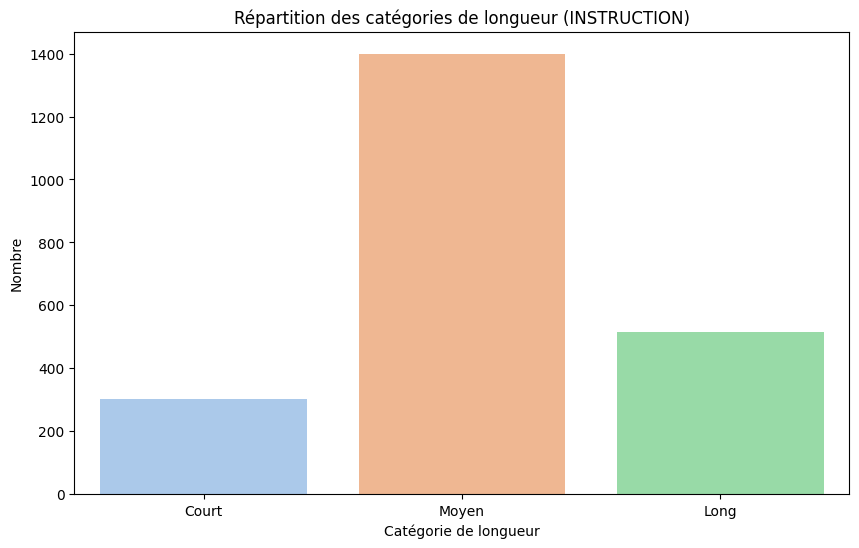

In [44]:
plt.figure(figsize=(10, 6))
sns.countplot(x='INSTRUCTION_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])
plt.title('Répartition des catégories de longueur (INSTRUCTION)')
plt.xlabel('Catégorie de longueur')
plt.ylabel('Nombre')
plt.show()

La majorité des instructions se trouvent dans la catégorie **Moyen** (50-150 caractères), ce qui suggère que les consignes sont généralement bien équilibrées entre brièveté et clarté. Les instructions longues (> 150 caractères) constituent une part notable, apportant probablement un contexte plus détaillé pour des réponses plus complexes. Enfin, les instructions courtes (< 50 caractères) sont les moins fréquentes, reflétant une préférence pour des consignes fournissant un minimum de contexte. Cette répartition diversifiée offre un bon équilibre pour entraîner un modèle capable de gérer différentes complexités d'instructions.

<ipython-input-45-8c1d34c3c3d3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RESPONSE_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])


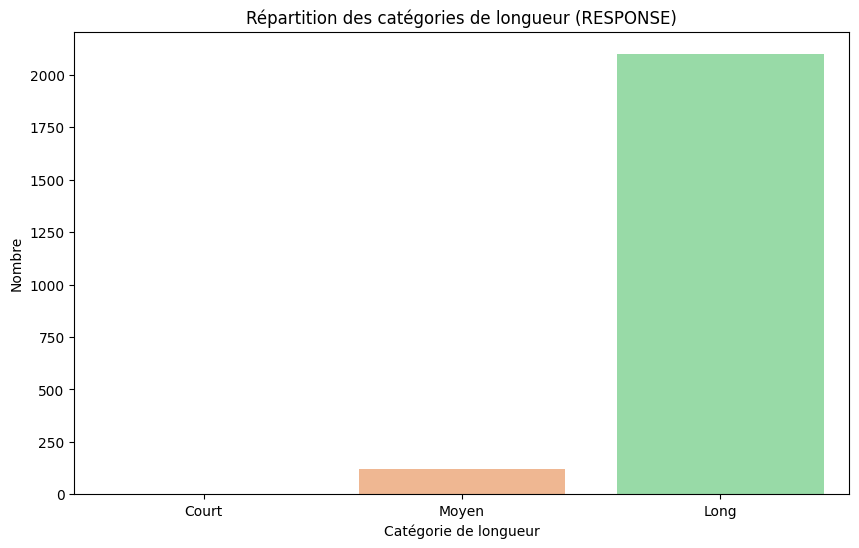

In [45]:
plt.figure(figsize=(10, 6))
sns.countplot(x='RESPONSE_category', data=train_df, palette="pastel", order=['Court', 'Moyen', 'Long'])
plt.title('Répartition des catégories de longueur (RESPONSE)')
plt.xlabel('Catégorie de longueur')
plt.ylabel('Nombre')
plt.show()

La majorité des réponses appartiennent à la catégorie **Long** (> 150 caractères), ce qui indique que les poèmes générés sont généralement détaillés et développés, fournissant un contenu riche en réponse aux instructions. Les réponses de longueur moyenne (50-150 caractères) sont rares, tandis que les réponses courtes (< 50 caractères) sont presque inexistantes, montrant une préférence marquée pour des réponses substantiellement élaborées. Cette répartition est cohérente avec l'objectif de générer des poèmes riches et expressifs, bien adaptés au contexte des instructions.

**Distribution des Longueurs**

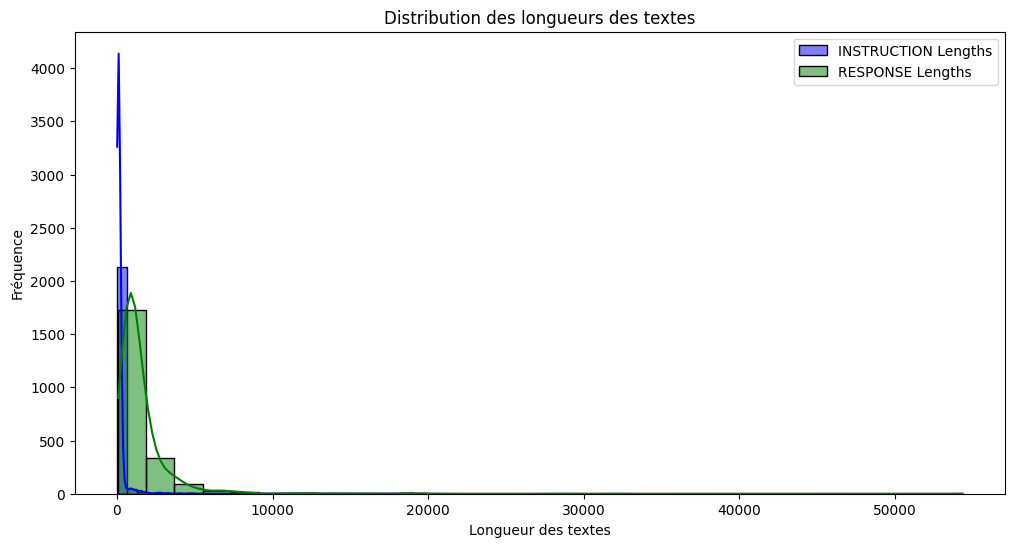

In [46]:
# Visualisation des distributions des longueurs
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(train_df['INSTRUCTION_length'], bins=30, kde=True, label="INSTRUCTION Lengths", color='blue')
sns.histplot(train_df['RESPONSE_length'], bins=30, kde=True, label="RESPONSE Lengths", color='green')
plt.title('Distribution des longueurs des textes')
plt.xlabel('Longueur des textes')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

Ce graphe montre une nette différence entre la distribution des longueurs des instructions et des réponses. Les instructions, généralement comprises entre **50 et 200 caractères**, sont relativement courtes et concentrées autour d'une moyenne basse, indiquant leur rôle de consignes claires et concises. En revanche, les réponses sont beaucoup plus longues, avec une large distribution allant jusqu'à **plus de 50 000 caractères**, reflétant la richesse et la profondeur des poèmes générés. Cette distinction est cohérente avec le besoin d'instructions simples pour produire des sorties détaillées et élaborées.

**Analyse de la diversité lexicale**

In [47]:
import re

def calculate_lexical(column):
    # Combiner tout le texte en une seule chaîne
    all_text = ' '.join(column)

    # convertir tout en minuscules et retirer les ponctuations
    all_text_cleaned = re.sub(r'[^\w\s]', '', all_text.lower())

    # Séparer les mots
    words = all_text_cleaned.split()

    # Identifier les mots uniques
    unique_words = set(words)

    # Calculer la diversité lexicale
    return len(unique_words) / len(words) if len(words) > 0 else 0

In [48]:
INSTRUCTION_diversity = calculate_lexical(train_df['INSTRUCTION'])
RESPONSE_diversity = calculate_lexical(train_df['RESPONSE'])

print("Diversité lexicale (INSTRUCTION): ", INSTRUCTION_diversity)
print("Diversité lexicale (RESPONSE): ", RESPONSE_diversity)

Diversité lexicale (INSTRUCTION):  0.1579428989751098
Diversité lexicale (RESPONSE):  0.08646411828014161


**1. Diversité lexicale des instructions** : **0.16**  
   - Environ **16%** des mots dans les instructions sont uniques, ce qui montre une diversité modérée. Cela reflète la variété des consignes, avec des termes qui reviennent fréquemment pour structurer les demandes.

**2. Diversité lexicale des réponses** : **0.09%**  
   - La diversité lexicale est nettement plus faible pour les réponses, avec environ **9%** de mots uniques. Cela indique une utilisation récurrente de motifs poétiques ou stylistiques propres à la génération de poèmes.

**Corrélation entre la longueur des instructions et des poeme**

In [49]:
length_correlation = train_df['INSTRUCTION_length'].corr(train_df['RESPONSE_length'])
print("Corrélation des longueurs: ", length_correlation)

Corrélation des longueurs:  -0.06268968042780167


La corrélation légèrement négative (**-0.06**) entre la longueur des instructions et celle des réponses indique qu'il n'existe presque aucune relation linéaire entre ces deux variables. Cela suggère que la longueur des poèmes générés ne dépend pas directement de la longueur des instructions.

**Similarité entre instructions et réponses**

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(train_df['INSTRUCTION'] + train_df['RESPONSE'])

# Calcul de similarité moyenne
cosine_similarities = cosine_similarity(tfidf_matrix)
average_similarity = cosine_similarities.mean()

average_similarity

0.025670637650026643

La similarité cosinus moyenne est faible (**0.0256**), indiquant que les instructions et réponses du dataset ont un contenu lexical globalement peu similaire, ce qui reflète une bonne diversité dans les données.

In [51]:
def classify_sentence_type(text):
    if '?' in text:
        return 'question'
    elif '!' in text:
        return 'exclamation'
    else:
        return 'neutral'

train_df['INSTRUCTION_type'] = train_df['INSTRUCTION'].apply(classify_sentence_type)
train_df['RESPONSE_type'] = train_df['RESPONSE'].apply(classify_sentence_type)

# Proportions des types
INSTRUCTION_type_distribution = train_df['INSTRUCTION_type'].value_counts(normalize=True)
RESPONSE_type_distribution = train_df['RESPONSE_type'].value_counts(normalize=True)

In [52]:
print("Instruction Type Distribution: \n",INSTRUCTION_type_distribution)

Instruction Type Distribution: 
 INSTRUCTION_type
neutral        0.755525
question       0.241768
exclamation    0.002706
Name: proportion, dtype: float64


In [53]:
print("Resonse Type Distribution: \n",RESPONSE_type_distribution)

Resonse Type Distribution: 
 RESPONSE_type
neutral        0.524132
question       0.341001
exclamation    0.134867
Name: proportion, dtype: float64


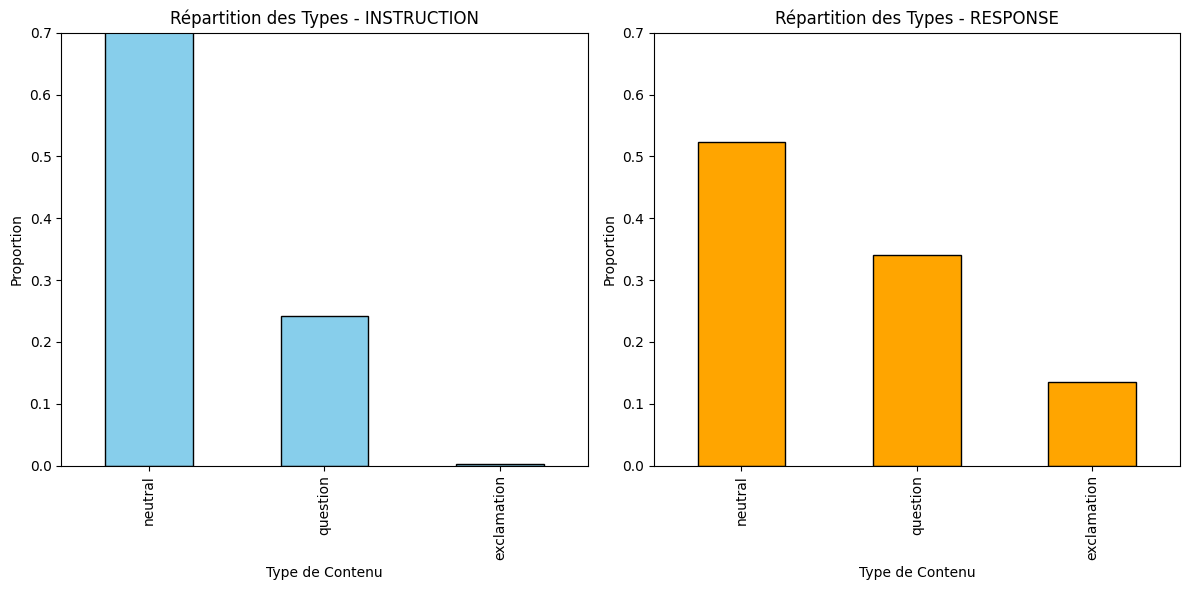

In [54]:
# Visualisation des distributions des types
plt.figure(figsize=(12, 6))

# Distribution des types des instructions
plt.subplot(1, 2, 1)
INSTRUCTION_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Répartition des Types - INSTRUCTION')
plt.xlabel('Type de Contenu')
plt.ylabel('Proportion')
plt.ylim(0, 0.7)

# Distribution des types des réponse
plt.subplot(1, 2, 2)
RESPONSE_type_distribution.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Répartition des Types - RESPONSE')
plt.xlabel('Type de Contenu')
plt.ylabel('Proportion')
plt.ylim(0, 0.7)

plt.tight_layout()
plt.show()

**1. Instructions (INSTRUCTION)** :
   - La majorité des instructions (**75%**) sont de type **neutre**, indiquant qu'elles sont souvent des demandes ou des consignes simples, sans question ni exclamation.
   - Les instructions de type **question** représentent environ **24%**, ce qui reflète des demandes formulées sous forme interrogative.
   - Les instructions avec des exclamations sont très rares (**0.2%**), soulignant que peu de consignes expriment un ton particulièrement emphatique.

**2. Réponses (RESPONSE)** :
   - Les réponses **neutres** restent dominantes (**52%**), mais leur proportion est réduite par rapport aux instructions.
   - Les réponses de type **question** augmentent significativement (**34%**), ce qui peut refléter un style interactif ou des réponses cherchant à engager l'utilisateur.
   - Les réponses avec des **exclamations** sont également plus fréquentes (**13%**), probablement en raison du style poétique qui favorise des expressions emphatiques.

Ce contraste montre que les réponses adoptent un style plus expressif et interactif, s'écartant des instructions qui sont principalement neutres et informatives.

#**2. Nettoyage des données**

Après toute cette exploration effectuée sur nos données (longueurs, similarités, etc.), nous pouvons affirmer que nos données sont bien nettoyées et prêtes à être utilisées pour le fine-tuning de notre modèle 'Mistral'.
C'est ce que nous allons voir dans la suite.

#**3. Préparation des données** :

Configuration de l'utilisation du GPU

In [55]:
import torch
device_map = {"": torch.cuda.current_device()} if torch.cuda.is_available() else None

Authentification avec Hugging Face

Chargement du modèle et du tokenizer et application de QLoRA

In [ ]:
model_name = "openai-community/gpt2"

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
  )
# Désactiver use_cache et activer gradient_checkpointing
model.config.use_cache = False
model.gradient_checkpointing_enable()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
model.print_trainable_parameters()

trainable params: 2,359,296 || all params: 126,799,104 || trainable%: 1.8607


Test du modèle avant le fine tuning

preparer les entre et les sorti avec la prompte :

In [56]:
Role = "You are a poet who writes in a lyrical and evocative style"
Task = "Write a poem based on this INSTRUCTION"

In [56]:
print(train_df['INSTRUCTION'][7187])

Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.


In [57]:
input = f"""Role : {Role} \n\nINSTRUCTION: {train_df['INSTRUCTION'][7187]}\nTask: {Task}\n\n assistant : """

In [ ]:
tokenized_input = tokenizer(input, return_tensors="pt", padding=True, truncation=True, max_length=300)

In [ ]:
model_answer = model.generate(
    input_ids = tokenized_input.input_ids.to(model.device),
    attention_mask = tokenized_input.attention_mask.to(model.device),
    max_new_tokens=350,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    # top_k=80,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    )

In [ ]:
decoded_answer = tokenizer.decode(model_answer[0], skip_special_tokens=True)
print(decoded_answer)

Role : You are a poet who writes in a lyrical and evocative style 

INSTRUCTION: Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.
Task: Write a poem based on this INSTRUCTION

 assistant : _________

TEMPLATE: Draw a model of the poem you want to draw.


INTERFACE: Draw a blank image on the page. Let it draw the picture you want.


WORKSHOP: Write a notebook notebook. Write a journal. Write a sketch


LOSS: Take out any possessions.


RESURRECTION

The project gets better.

It gets harder.

A whole series of changes happen.

They make it easier for you to write this type of article.

But they make it harder for you to write things in a way that would be enjoyable for someone who just wants to write something.

It is this type OF writing that the author needs.

No matter what he's trying to accomplish.

This type of writing is very hard for everyone.

You become much more skilled at it


In [57]:
Role = "You are a poet who writes in a lyrical and evocative style, Write a poem based on the user `INSTRUCTION`"

In [58]:
for index, row in train_df.iterrows():
  i = index
  train_df.loc[index, 'input_text'] = f"""Role: {Role}\n\nINSTRUCTION: {row['INSTRUCTION']}\n\nAssistant : """
  train_df.loc[index, 'output_text'] = f"""Assistant : Poem :{row['RESPONSE']}"""

In [59]:
for index, row in test_df.iterrows():
  i = index
  test_df.loc[index, 'input_text'] = f"""Role: {Role}\n\nINSTRUCTION: {row['INSTRUCTION']}\n\nAssistant : """
  test_df.loc[index, 'output_text'] = f"""Assistant : Poem :{row['RESPONSE']}"""

In [60]:
for index, row in validation_df.iterrows():
  i = index
  validation_df.loc[index, 'input_text'] = f"""Role: {Role}\n\nINSTRUCTION: {row['INSTRUCTION']}\n\nAssistant : """
  validation_df.loc[index, 'output_text'] = f"""Assistant : Poem :{row['RESPONSE']}"""

In [61]:
new_train_df = train_df[['input_text', 'output_text']]

In [62]:
new_test_df = test_df[['input_text', 'output_text']]

In [63]:
new_validation_df = validation_df[['input_text', 'output_text']]

Séparation des données en ensembles d'entrée `X` et de sortie `y` pour l'entraînement, la validation et les tests

In [64]:
from datasets import Dataset

# Convertir les DataFrames pandas en Datasets Hugging Face
train_dataset = Dataset.from_pandas(new_train_df)
validation_dataset = Dataset.from_pandas(new_validation_df)
test_dataset = Dataset.from_pandas(new_test_df)

Tokenisation des données d'entrée (instructions) et de sortie (poemes) pour l'entraînement, la validation et les tests

Adaptation des datasets d'entraînement, de validation et de test pour le fine-tuning

In [ ]:
def tokenize_function(examples):
    # Tokenisation des données
    inputs = tokenizer(
        examples['input_text'], truncation=True, padding='max_length', max_length=250
    )
    labels = tokenizer(
        examples['output_text'], truncation=True, padding='max_length', max_length=250
    )

    # Ajouter les labels alignés
    inputs['labels'] = labels['input_ids']
    return inputs

In [ ]:
# Tokeniser les datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = validation_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_dataset[0])  # Exemple d'un batch tokenisé

{'input_text': 'Role: You are a poet who writes in a lyrical and evocative style\n\nINSTRUCTION: Make a poem with themes of Social Commentaries,Cities & Urban Life.Generate a poem with the following themes: Social Commentaries,Cities & Urban Life.\nTask: Write a poem based on this INSTRUCTION\n\nAssistant : ', 'output_text': 'Assistant : Poem :Okay, a poem about Social Commentaries,Cities & Urban Life: \n"The Lights of London"\nThe evenfall, so slow on hills, hath shot Far down into the valley’s cold extreme, Untimely midnight; spire and roof and stream Like fleeing specters, shudder and are not. The Hampstead hollies, from their sylvan plot Yet cloudless, lean to watch as in a dream, From chaos climb with many a sudden gleam, London, one moment fallen and forgot. Her booths begin to flare; and gases bright Prick door and window; all her streets obscure Sparkle and swarm with nothing true nor sure, Full as a marsh of mist and winking light; Heaven thickens over, Heaven that cannot cure

#**4. Fine-tuning du modèle**

Gestion et optimisation de la mémoire GPU

In [64]:
import torch
torch.cuda.empty_cache()

In [65]:
!nvidia-smi

Mon Feb 10 09:09:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [66]:
!kill -9 <pid>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kill -9 <pid>'


In [67]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


Initialisation de l'accélérateur

In [68]:
import os
from accelerate import Accelerator
#Configuration des variables d'environnement pour optimiser l'efficacité GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"

# Initialisation de l'accélérateur
accelerator = Accelerator(mixed_precision="fp16")

Initialisation de DataCollator

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

Définition des arguments pour l'entraînement du modèle

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

output_dir = "data/gpt_2-sft-lora_v0.1"

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    fp16=True,
    save_steps=2000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    gradient_checkpointing=True,
    optim="adamw_torch",
    report_to="none",
    eval_accumulation_steps=2
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Fonction de calcul des métriques d'évaluation du modèle

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # Convertir les prédictions et les labels en texte
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Filtrer les labels pour exclure les IDs hors du vocabulaire
    filtered_labels = [
        [token_id for token_id in l if 0 <= token_id < tokenizer.vocab_size]
        for l in labels
    ]
    decoded_labels = tokenizer.batch_decode(filtered_labels, skip_special_tokens=True)

    # Calculer les scores ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = [scorer.score(pred, label) for pred, label in zip(decoded_preds, decoded_labels)]

    rouge1 = sum(score["rouge1"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge2 = sum(score["rouge2"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rougeL = sum(score["rougeL"].fmeasure for score in rouge_scores) / len(rouge_scores)

    # Calculer la similarité cosinus
    vectorizer = TfidfVectorizer().fit(decoded_preds + decoded_labels)
    tfidf_preds = vectorizer.transform(decoded_preds)
    tfidf_labels = vectorizer.transform(decoded_labels)
    similarities = [cosine_similarity(tfidf_preds[i], tfidf_labels[i])[0][0] for i in range(len(decoded_preds))]
    avg_similarity = sum(similarities) / len(similarities)

    # Calculer le score BLEU
    smoothing_function = SmoothingFunction().method1  # Utilise une méthode pour éviter les problèmes avec des petits n-grammes
    bleu_scores = [
        sentence_bleu([label.split()], pred.split(), smoothing_function=smoothing_function)
        for pred, label in zip(decoded_preds, decoded_labels)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    return {
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
        "similarity": avg_similarity,
        "bleu": avg_bleu,
    }

Initialisation du Trainer pour le Fine-Tuning

In [ ]:
# Initialiser le trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

<ipython-input-93-407a79b4ddcb>:2: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Lancement de l'entraînement du modèle

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Similarity,Bleu
1,0.740000,0.674838,0.824502,0.722810,0.815853,0.513990,0.681105
2,0.703300,0.573117,0.832647,0.731842,0.824128,0.534146,0.688740
3,1.084600,0.551488,0.834582,0.734295,0.826877,0.545731,0.687167


TrainOutput(global_step=6651, training_loss=0.7871943896757071, metrics={'train_runtime': 1469.9611, 'train_samples_per_second': 4.525, 'train_steps_per_second': 4.525, 'total_flos': 872098700544000.0, 'train_loss': 0.7871943896757071, 'epoch': 3.0})

Évaluation finale du modèle sur l'ensemble de test

In [ ]:
results = trainer.evaluate()

In [ ]:
print("Résultats de l'évaluation :\n")
results

Résultats de l'évaluation :



{'eval_loss': 0.5514876842498779,
 'eval_rouge1': 0.8345821245792884,
 'eval_rouge2': 0.7342950079813487,
 'eval_rougeL': 0.8268765768139696,
 'eval_similarity': 0.5457313101195924,
 'eval_bleu': 0.6871669528244376,
 'eval_runtime': 352.3701,
 'eval_samples_per_second': 0.786,
 'eval_steps_per_second': 0.786,
 'epoch': 3.0}

# **5. Évaluation des performances**

Connexion à Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sauvegarde et exportation du modèle

In [ ]:
trainer.save_model("/content/drive/MyDrive/projet_Gen_ia/gpt2_on_instruction_poems")

Chargement du modèle finetuner depuis Google Drive

In [69]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "/content/drive/MyDrive/projet_Gen_ia/gpt2_on_instruction_poems"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

Attribution du modèle à l'appareil approprié (GPU ou CPU)

In [2]:
# device_map = "cuda" if torch.cuda.is_available() else "cpu"
# if torch.cuda.is_available():
#     model = model.to(device_map)
#     print("model is in the device")
# else:
#     model = model.to("cpu")

model is in the device


In [65]:
new_validation_df.head()

,input_text,output_text
1542,Role: You are a poet who writes in a lyrical a...,"Assistant : Poem :Of course! It's called ""The ..."
260,Role: You are a poet who writes in a lyrical a...,"Assistant : Poem :Of course! It's called ""Immo..."
7455,Role: You are a poet who writes in a lyrical a...,"Assistant : Poem :It's called ""Reemergence of ..."
7651,Role: You are a poet who writes in a lyrical a...,Assistant : Poem :Here's your poem about Activ...
10262,Role: You are a poet who writes in a lyrical a...,Assistant : Poem :I've written a poem for you ...


In [70]:
new_test_df["input_text"]

,input_text
12086,Role: You are a poet who writes in a lyrical a...
13246,Role: You are a poet who writes in a lyrical a...
5901,Role: You are a poet who writes in a lyrical a...
5420,Role: You are a poet who writes in a lyrical a...
3493,Role: You are a poet who writes in a lyrical a...
...,...
9382,Role: You are a poet who writes in a lyrical a...
10462,Role: You are a poet who writes in a lyrical a...
7848,Role: You are a poet who writes in a lyrical a...
9610,Role: You are a poet who writes in a lyrical a...


Fonction pour générer des prédictions et sauvegarder les résultats

In [71]:
def generate_poeme(dataset, output_file):
    results = []
    for index, row in dataset.iterrows():
        i = index
        input = row['input_text']
        output = row['output_text']

        # Tokenize input, but keep it on CPU initially
        tokenized_input = tokenizer(input, return_tensors="pt", max_length=254, padding=True, truncation=True)

        # Move input tensors to GPU inside the try block
        input_ids = tokenized_input["input_ids"].to(model.device)
        attention_mask = tokenized_input["attention_mask"].to(model.device)

        response = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=800,
            temperature=0.6,
            top_k=60,
            pad_token_id=tokenizer.eos_token_id
        )

        response_text = tokenizer.decode(response[0], skip_special_tokens=True)
        predicted_poeme = response_text
        ture_poeme = output
        results.append({
            "Index": index,
            "Entred_prompt": input,
            "Model_response": response_text,
            "Ture_poeme": ture_poeme,
            "Predicted_poeme": predicted_poeme,
        })

        print("predicted_poeme : ", predicted_poeme)
        print("#"*100)
        print("response_text  : ", response_text)

    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    print(f"Les prédictions ont été enregistrées dans {output_file}")

Nous allons tester sur notre jeu de données de test:

In [75]:
new_test_df.shape

(277, 2)

Génération des prédictions :

In [72]:
generate_poeme(new_test_df, "/content/drive/MyDrive/projet_Gen_ia/gpt_2_test_df.csv")

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `60` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


predicted_poeme :  Role: You are a poet who writes in a lyrical and evocative style, Write a poem based on the user `INSTRUCTION`

INSTRUCTION: I want a poem about Activities,Travels & Journeys,Nature,Stars, Planets, Heavens,Arts & Sciences,Music,Social Commentaries,Race & Ethnicity.

Assistant :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Chargement des prédictions générées depuis les fichiers sauvegardés

In [3]:
import pandas as pd

In [4]:
testdata = pd.read_csv("/content/drive/MyDrive/projet_Gen_ia/gpt_2_test_df.csv")

In [6]:
testdata.head()

,Index,Entred_prompt,Model_response,Ture_poeme,Predicted_poeme
0,12086,<|system|>role: You are a creative assistant....,<s> <|system|>role: You are a creative assista...,"I've written a poem for you about Activities,T...","</s>|Poem|\r\n\r\nIn the heart of the city, wh..."
1,13246,<|system|>role: You are a creative assistant....,<s> <|system|>role: You are a creative assista...,"How about calling it ""The Spider""? \nSource: P...","</s><s>I'll call this poem ""The Spider and the..."
2,5901,<|system|>role: You are a creative assistant....,<s> <|system|>role: You are a creative assista...,"Of course! It's called ""The Window"": \nyou are...",</s>|Relationships|
3,5420,<|system|>role: You are a creative assistant....,<s> <|system|>role: You are a creative assista...,"I've written a poem for you about Living,Death...",</s>|Sorrow & Grieving|Love|Realistic & Compli...
4,3493,<|system|>role: You are a creative assistant....,<s> <|system|>role: You are a creative assista...,"I've written a poem for you about Love,Break-u...",</s>|Break-ups & Vexed Love|\r\n\r\nWhen the s...


###**Évaluation des prédictions générées**

Dans cette section, nous évaluons les poèmes générés par le modèle en utilisant des métriques telles que **ROUGE** et la **similarité cosinus**. Cette évaluation compare les poèmes générés avec les véritables poèmes présents dans notre dataset, permettant d'analyser leur cohérence, leur pertinence, et leur fidélité aux instructions données. Le calcul comprend :

- **ROUGE-1, ROUGE-2, ROUGE-L** : Mesurent la précision des prédictions en termes de correspondance lexicale avec les poèmes de référence.
- **Similarité cosinus** : Évalue la proximité sémantique entre les poèmes générés et les poèmes de référence, tout en tenant compte des nuances thématiques.

In [8]:
!pip install evaluate

In [9]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=017dfc555fdb6c46159a5340a32944597ff0a7890486e48593cdcb57bcd07ac7
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import pandas as pd

def evaluate_generated_poeme(test_data_path):
    # Charger les données générées
    test_data = pd.read_csv(test_data_path)

    # Vérifier si les colonnes nécessaires sont présentes
    required_columns = ["Ture_poeme", "Predicted_poeme"]
    for column in required_columns:
        if column not in test_data.columns:
            raise ValueError(f"La colonne '{column}' est manquante !!!")

    # Récupérer les vraies poemes et générées et remplacer les NaN par des chaînes vides
    Ture_poeme = test_data["Ture_poeme"].fillna("")
    Predicted_poeme = test_data["Predicted_poeme"].fillna("")

    # Initialiser le calculateur ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = [scorer.score(pred, label) for pred, label in zip(Predicted_poeme, Ture_poeme)]

    # Calculer les scores moyens ROUGE
    rouge1 = sum(score["rouge1"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge2 = sum(score["rouge2"].fmeasure for score in rouge_scores) / len(rouge_scores)
    rougeL = sum(score["rougeL"].fmeasure for score in rouge_scores) / len(rouge_scores)

    # Calculer la similarité cosinus
    vectorizer = TfidfVectorizer().fit(Predicted_poeme + Ture_poeme)
    tfidf_preds = vectorizer.transform(Predicted_poeme)
    tfidf_labels = vectorizer.transform(Ture_poeme)
    similarities = [
        cosine_similarity(tfidf_preds[i], tfidf_labels[i])[0][0] for i in range(len(Predicted_poeme))
    ]
    avg_similarity = sum(similarities) / len(similarities)

    decoded_preds = Predicted_poeme.tolist()
    decoded_labels = Ture_poeme.tolist()

    # Calculer le score BLEU
    smoothing_function = SmoothingFunction().method1  # Utilise une méthode pour éviter les problèmes avec des petits n-grammes
    bleu_scores = [
        sentence_bleu([label.split()], pred.split(), smoothing_function=smoothing_function)
        for pred, label in zip(decoded_preds, decoded_labels)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # Retourner les métriques
    return {
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
        "bleu": avg_bleu,
        "similarity": avg_similarity,
    }

In [ ]:
# Chemin de notre testdataset.csv
test_data_path = "/content/drive/MyDrive/projet_Gen_ia/gpt_2_test_df.csv"

# évaluation
metrics = evaluate_generated_poeme(test_data_path)

# Afficher les résultats
print("Résultats de l'évaluation :")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

### **Visualisations des resultats :**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
test_data = pd.read_csv(test_data_path)

# Graphique à barres des scores ROUGE
def plot_rouge_scores(metrics):
    rouge_data = {
        "ROUGE-1": metrics["rouge1"],
        "ROUGE-2": metrics["rouge2"],
        "ROUGE-L": metrics["rougeL"],
    }
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(rouge_data.keys()), y=list(rouge_data.values()), palette="Blues_d")
    plt.title("Scores ROUGE moyens")
    plt.xlabel("Type de ROUGE")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

In [ ]:
# Visualiser les résultats
print("Visualisation des scores ROUGE")
plot_rouge_scores(metrics)

**Distribution des similarités cosinus**

In [14]:
def plot_cosine_similarity_distribution(similarities):
    plt.figure(figsize=(8, 6))
    sns.histplot(similarities, bins=30, kde=True, color="green")
    plt.title("Distribution des similarités cosinus")
    plt.xlabel("Similarité cosinus")
    plt.ylabel("Fréquence")
    plt.xlim(0, 1)
    plt.show()

In [ ]:
print("Visualisation des similarités cosinus")
cosine_similarities = metrics["similarity"]
plot_cosine_similarity_distribution([cosine_similarities])

**Comparaison des longueurs des textes générés et des vérités de référence**

In [16]:
def plot_length_comparison(test_data):
    test_data["True_poeme_length"] = test_data["Ture_poeme"].fillna("").apply(len)
    test_data["Predicted_poeme_length"] = test_data["Predicted_poeme"].fillna("").apply(len)

    plt.figure(figsize=(8, 6))
    sns.histplot(test_data["True_poeme_length"], bins=30, color="blue", label="Longueur des poemes vraies", kde=True)
    sns.histplot(test_data["Predicted_poeme_length"], bins=30, color="orange", label="Longueur des poemes générées", kde=True)
    plt.title("Distribution des longueurs des poemes")
    plt.xlabel("Longueur des poemes")
    plt.ylabel("Fréquence")
    plt.legend()
    plt.show()

In [ ]:
print("Comparaison des longueurs des poemes")
plot_length_comparison(testdata)